In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Libraries

In [49]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import os


#Dataset Merge

In [74]:
import pandas as pd

# Load farm density data (external factor influencing outbreaks)
farm_density_df = pd.read_csv("/content/drive/My Drive/Farm density.csv")

# Load avian case data from the APHA Avian Dashboard dataset
dataset_prt_df = pd.read_csv("/content/drive/My Drive/Dataset_PRT 564.csv")

# Clean 'Region' names to ensure consistency between datasets
farm_density_df['Region'] = farm_density_df['Region'].str.strip().str.lower()
dataset_prt_df['Region'] = dataset_prt_df['Region'].str.strip().str.lower()

# Aggregate case counts by Region, Year, and Month (spatial-temporal grouping)
cases_by_region_month = (
    dataset_prt_df
    .groupby(['Region', 'Year', 'Month'])
    .size()
    .reset_index(name='Case_Count')
)

# Merge the farm density data into the aggregated dataset on the 'Region' field
merged_df = pd.merge(cases_by_region_month, farm_density_df, on='Region', how='left')

# Identify and report regions missing farm density data
print("Regions with missing farm data:", merged_df[merged_df['<5 ha'].isna()]['Region'].unique())

# Drop rows with missing farm density info to ensure data integrity
merged_df_cleaned = merged_df.dropna(subset=['<5 ha'])

# Preview the merged and cleaned dataset
merged_df_cleaned.head()


Regions with missing farm data: ['all' 'ayrshire' 'buckinghamshire' 'carmarthenshire' 'ceredigion'
 'cornwall and isles of scilly' 'cumbria' 'derbyshire' 'devon' 'dorset'
 'duhram' 'east riding and north lincolnshire' 'eicestershire and rutland'
 'greater london' 'hertfordshire' 'kent' 'lincolnshire' 'london' 'lothian'
 'north west wales' 'northamptonshire' 'nottinghamshire' 'oxfordshire'
 'pembrokeshire' 'scotland' 'scotlands' 'scottish borders' 'shropshire'
 'somerset excl north' 'south east' 'south wales' 'south weest'
 'staffordshire' 'wales' 'warwickshire']


,Region,Year,Month,Case_Count,<5 ha,5<20 ha,20<50 ha,50<100 ha,≥100 ha,Total
23,east midlands,2012,3,1,0.12,0.25,0.19,0.16,0.28,1.0
24,east midlands,2012,5,5,0.12,0.25,0.19,0.16,0.28,1.0
25,east midlands,2012,7,2,0.12,0.25,0.19,0.16,0.28,1.0
26,east midlands,2012,8,2,0.12,0.25,0.19,0.16,0.28,1.0
27,east midlands,2012,9,1,0.12,0.25,0.19,0.16,0.28,1.0


Merging both datasets ensures data heterogeneity.

Aggregating by month and region prepares the data for meaningful temporal analysis.

Cleaning ensures model accuracy and avoids training on incomplete or mismatched records.

#Feature Engineering and Preprocessing

In [75]:
from sklearn.preprocessing import StandardScaler

# Define predictor variables (features) and the outcome (target)
features = ['<5 ha', '5<20 ha', '20<50 ha', '50<100 ha', '≥100 ha', 'Year', 'Month']
target = 'Case_Count'

X = merged_df_cleaned[features]
y = merged_df_cleaned[target]

# Normalize features for scale-invariant model training
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Display dimensions for verification
print("Feature matrix shape:", X_scaled.shape)
print("Target variable shape:", y.shape)


Feature matrix shape: (135, 7)
Target variable shape: (135,)


Standardizing helps regression models (especially linear) perform better by aligning feature scales.

Farm size distribution and time indicators are logically selected features based on domain knowledge.

#Regression Modelling and Evaluation

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80/20) for evaluation
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Initialize and train Decision Tree Regressor (non-linear alternative)
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
tree_preds = tree_model.predict(X_test)

# Define function to print evaluation results
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Results")
    print("R² Score:", r2_score(y_true, y_pred))  # Indicates proportion of variance explained
    print("MSE:", mean_squared_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))

# Compare both models using evaluation metrics
evaluate_model("Linear Regression", y_test, lr_preds)
evaluate_model("Decision Tree Regression", y_test, tree_preds)




Linear Regression Results
R² Score: -0.17630637875694255
MSE: 0.6422084207753952
RMSE: 0.8013790743308657

Decision Tree Regression Results
R² Score: -0.8994974874371862
MSE: 1.037037037037037
RMSE: 1.0183501544346312


Linear Regression is interpretable and ideal for assessing feature impact.

Decision Tree handles non-linear relationships and may capture complex interactions.

R², MSE, and RMSE provide a robust model comparison.

#Poisson Regression with Interpretability and Residual Analysis

In [77]:
import statsmodels.api as sm

# Reconstruct DataFrame with features and target for statsmodels
df_poisson = merged_df_cleaned.copy()
df_poisson = df_poisson[features + ['Case_Count']]

# Add a constant (intercept) for Poisson regression
df_poisson = sm.add_constant(df_poisson)

# Fit a Poisson regression model (appropriate for count data like Case_Count)
poisson_model = sm.GLM(df_poisson['Case_Count'], df_poisson.drop(columns='Case_Count'),
                       family=sm.families.Poisson()).fit()

# Display summary with coefficients, standard errors, and p-values
print(poisson_model.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:             Case_Count   No. Observations:                  135
Model:                            GLM   Df Residuals:                      127
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -179.75
Date:                Tue, 22 Apr 2025   Deviance:                       50.584
Time:                        14:24:07   Pearson chi2:                     58.3
No. Iterations:                     4   Pseudo R-squ. (CS):            0.05729
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.5136     46.348      1.241      0.2

Poisson regression is ideal for count-based outcome variables.

Coefficients and p-values help determine statistically significant predictors (e.g., Year).

Can be interpreted in percentage terms for real-world policy impact.

#Residual Analysis

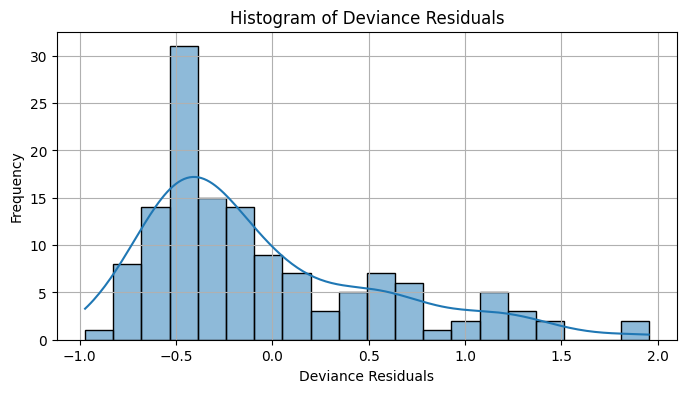

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract deviance residuals from Poisson model
residuals = poisson_model.resid_deviance

# Visualize distribution of residuals
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=20, kde=True)
plt.title('Histogram of Deviance Residuals')
plt.xlabel('Deviance Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



Residual analysis validates model assumptions.

A near-normal distribution of residuals suggests the model is well-specified.

#Likelihood Ratio Test

In [80]:
from statsmodels.discrete.discrete_model import NegativeBinomial
from scipy.stats import chi2

# Fit Negative Binomial model for comparison
nb_model = sm.GLM(df_poisson['Case_Count'], df_poisson.drop(columns='Case_Count'),
                  family=sm.families.NegativeBinomial()).fit()

# Likelihood ratio test to check if NB improves fit over Poisson
lr_stat = 2 * (nb_model.llf - poisson_model.llf)
p_value = chi2.sf(lr_stat, df=1)

print("Likelihood Ratio χ²:", lr_stat)
print("p-value:", p_value)



Likelihood Ratio χ²: -100.3833849638562
p-value: 1.0


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Helps test whether overdispersion (variance > mean) warrants a switch to Negative Binomial.

If p > 0.05, Poisson model is sufficient